# 
# Tracks' Genre Classification - [ *Team Emer* ]
# 

In [75]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pickle

# 
# Feature Selection

In [76]:
#################    ALL     #######################
# genre_names = ['Acoustic', 'R&B', 'Classical', 'Country', 'Electronic', 'Hiphop', 'Jazz', 'Pop', 'Rock', 'Reggae', "Rap"]
# feature_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness','liveness', 'valence', 'tempo']


##############     TYRONE    ####################
# genre_names = ['Rock', 'R&B', 'Acoustic']
# feature_cols =  ['danceability', 'energy', 'acousticness', 'valence', 'tempo']  #'loudness','speechiness', 'instrumentalness', 'liveness'


###############    RODS    #######################
genre_names = ['Classical', 'Reggae', 'Acoustic', 'R&B', 'Rock']
feature_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo'] #'liveness'


# ##############     G-AR    #######################
# genre_names = ['Rock', 'Hiphop', 'R&B', 'Folk', 'Indie', 'Acoustic']
# feature_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness','liveness', 'valence', 'tempo']


##############     KAYE    ####################
# genre_names = ['Rock', 'R&B', 'Acoustic', 'Country']
# feature_cols = ['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness','liveness', 'valence', 'tempo']




In [77]:
tracks = []
for i, KEYWORD in enumerate(genre_names):
    # Read and process the playlist data for keyword
    playlist_df = pd.read_csv('data/'+KEYWORD+'_playlist_data.csv')    
    tdf = pd.read_csv('data/'+KEYWORD+'_playlist_tracks_data.csv')\
    .merge(pd.read_csv('data/'+KEYWORD+'_playlist_tracks.csv')[['track_id','playlist_id','playlist_name']],\
                      on='track_id',how='left')
    
    # Make duration ms to minutes
    tdf['duration_mins'] = tdf['duration'] / 60000
    # Tag the 'genre' column with keyword then append to tmp 'tracks' dataframe
    tdf['genre'] = KEYWORD
    tdf['genre_id'] = i + 1
    tracks.append(tdf)
    
# Get union of all playlist tracks list
tracks_df = pd.concat(tracks)
# Clean the final dataframe for modeling
tracks_df = tracks_df.dropna(axis=1)
tracks_df['playlist_id'] = tracks_df['playlist_id_x']
tracks_df['playlist_name'] = tracks_df['playlist_name_x']
tracks_df = tracks_df.drop(['playlist_id_x', 'playlist_name_x', 'playlist_id_y', 'playlist_name_y'], axis=1)
tracks_df.isnull().any()

track_id            False
track_name          False
artist_id           False
artist_name         False
album_id            False
duration            False
release_date        False
popularity          False
danceability        False
energy              False
key                 False
loudness            False
mode                False
speechiness         False
acousticness        False
instrumentalness    False
liveness            False
valence             False
tempo               False
duration_mins       False
genre               False
genre_id            False
playlist_id         False
playlist_name       False
dtype: bool

# 
# Dataset *(Training and Test Sets)*

In [78]:
from sklearn.model_selection import train_test_split

# Create feature matrix (X)
X = tracks_df[feature_cols]
y = tracks_df['genre_id']

# Create the training set, test set  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ... and checking shapes
print("Shape of X_Train: " + str(X_train.shape))
print("Shape of y_Train: " + str(y_train.shape))
print("Shape of X_Test: " + str(X_test.shape))
print("Shape of y_Test: " + str(y_test.shape))

Shape of X_Train: (7852, 10)
Shape of y_Train: (7852,)
Shape of X_Test: (1963, 10)
Shape of y_Test: (1963,)


# 
# Feature Scaling

In [79]:
# Normalize numeric columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

tracks_df[feature_cols].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo
count,9815.000000,9815.000000,9815.000000,9815.000000,9815.000000,9815.000000,9815.000000,9815.000000,9815.000000,9815.000000
mean,0.537792,0.448438,5.240856,-11.951445,0.645441,0.072634,0.503711,0.253608,0.421843,115.732492
std,0.208274,0.288418,3.517035,7.803771,0.478404,0.072174,0.381275,0.386625,0.267827,32.501716
min,0.000000,0.000707,0.000000,-47.404000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000
25%,0.393000,0.174000,2.000000,-16.024000,0.000000,0.035600,0.113000,0.000000,0.186000,91.485000
50%,0.562000,0.462000,5.000000,-9.328000,1.000000,0.044900,0.471000,0.000449,0.399000,110.133000
75%,0.702000,0.698000,8.000000,-5.964500,1.000000,0.072500,0.915000,0.709500,0.642000,137.373500
max,0.969000,0.998000,11.000000,-0.432000,1.000000,0.907000,0.996000,0.990000,0.985000,235.935000


### Classification and Accuracy Result Function

In [80]:
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

classifiers = []

def classify(classifier, name, X_train, y_train, y_test, y_pred, cv=10):
    # evaluate accuracy
    acc = accuracy_score(y_test, y_pred) * 100
    print(f'\nThe accuracy of the {name} classifier is {acc} %')

    # show classification report
    print('\n\nClassification Report\n')
    print(classification_report(y_test, y_pred, target_names=genre_names))
    
    # show cross-validation accuracy
    accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=cv)
    print(f'\nCross-Validation Accuracy at cv={cv} is: {accuracies.mean() * 100} %\n')
    
    classifiers.append((classifier, name, accuracies.mean() * 100))
    # classifiers.append((classifier, name, acc))  ## use THIS(instead of above) to skip cross-validation accuracy metric to speed up this function call
    
    
    # save model object to file
    modelpath = f'models/{name.strip().lower()}.model.pickl'
    pickle.dump(classifier, open(f'{modelpath}', 'wb'))
    print(f'\n\nModel was saved at: "./{modelpath}"')
    


### Feature Importance DataFrame

In [81]:
def feature_importance(classifier):
    importances = list(classifier.feature_importances_) # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_cols, importances)] # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True) # Print out the feature and importances 
    importances_df = pd.DataFrame(feature_importances, columns=['Feature', 'Importance'])
    return importances_df

### Save DataFrame to CSV

In [82]:
def save_df_to_csv(df, filename):
    df.to_csv(f'data/{filename}.csv', index=False)
    print(f'Saved DataFrame with shape: {df.shape}')

# 
# kNN Classifier

In [83]:
from sklearn.neighbors import KNeighborsClassifier 

# kNN model tuning
cv_scores = []
neighbors = np.arange(2,51)

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    print(f'Fitting for k={k} \t with score={scores.mean()}')

# Changing to misclassification error
mse = [1 - x for x in cv_scores]

# Determine the best 'k'
optimal_k = neighbors[mse.index(min(mse))]
print(f'\nThe optimal number of neighbors for kNN classifier is k={optimal_k}.')

Fitting for k=2 	 with score=0.7116605889693846
Fitting for k=3 	 with score=0.7338197111878252
Fitting for k=4 	 with score=0.7368783326040096
Fitting for k=5 	 with score=0.7422255717087244
Fitting for k=6 	 with score=0.7449017033759582
Fitting for k=7 	 with score=0.7492308066319834
Fitting for k=8 	 with score=0.7493590055266527
Fitting for k=9 	 with score=0.7485958088199542
Fitting for k=10 	 with score=0.7492316169916208
Fitting for k=11 	 with score=0.7487214145637833
Fitting for k=12 	 with score=0.7526707832936257
Fitting for k=13 	 with score=0.7526702970778432
Fitting for k=14 	 with score=0.7521610670815708
Fitting for k=15 	 with score=0.7512696714802028
Fitting for k=16 	 with score=0.7510147323382117
Fitting for k=17 	 with score=0.7497413332036758
Fitting for k=18 	 with score=0.7484677719972124
Fitting for k=19 	 with score=0.7488505858900181
Fitting for k=20 	 with score=0.7491039043127341
Fitting for k=21 	 with score=0.7502505631999481
Fitting for k=22 	 with scor

## Optimal kNN Model

In [84]:
# Train the model
classifier = KNeighborsClassifier(n_neighbors=optimal_k)
classifier.fit(X_train, y_train)

# Test the prediction
y_pred = classifier.predict(X_test)

# Show the classification and accuracy result
classify(classifier=classifier, name='kNN', X_train=X_train, y_train=y_train, y_test=y_test, y_pred=y_pred)


The accuracy of the kNN classifier is 76.61742231278656 %


Classification Report

              precision    recall  f1-score   support

   Classical       0.91      0.93      0.92       549
      Reggae       0.70      0.87      0.77       372
    Acoustic       0.70      0.74      0.72       397
         R&B       0.53      0.28      0.36       225
        Rock       0.78      0.75      0.76       420

    accuracy                           0.77      1963
   macro avg       0.72      0.71      0.71      1963
weighted avg       0.76      0.77      0.75      1963


Cross-Validation Accuracy at cv=10 is: 75.26707832936256 %



Model was saved at: "./models/knn.model.pickl"


# 
# Support Vector Machine Classifiers

In [85]:
from sklearn.svm import SVC

## SVM (Linear Kernel) Classifier

In [86]:
# Train the model
classifier = SVC(kernel='linear', probability=True)
classifier.fit(X_train, y_train) 

# Test the prediction
y_pred = classifier.predict(X_test)

# Show the classification and accuracy result
classify(classifier=classifier, name='SVM (Linear Kernel)', X_train=X_train, y_train=y_train, y_test=y_test, y_pred=y_pred)


The accuracy of the SVM (Linear Kernel) classifier is 76.20988283239939 %


Classification Report

              precision    recall  f1-score   support

   Classical       0.90      0.93      0.91       549
      Reggae       0.70      0.85      0.77       372
    Acoustic       0.71      0.71      0.71       397
         R&B       0.55      0.26      0.36       225
        Rock       0.74      0.79      0.76       420

    accuracy                           0.76      1963
   macro avg       0.72      0.71      0.70      1963
weighted avg       0.75      0.76      0.75      1963


Cross-Validation Accuracy at cv=10 is: 75.0506312701577 %



Model was saved at: "./models/svm (linear kernel).model.pickl"


## SVM (Polynomial Kernel) Classifier

In [87]:
# Train the model
classifier = SVC(kernel='poly', degree=3, gamma=0.9, probability=True)
classifier.fit(X_train, y_train) 

# Test the prediction
y_pred = classifier.predict(X_test)

# Show the classification and accuracy result
classify(classifier=classifier, name='SVM (Polynomial Kernel)', X_train=X_train, y_train=y_train, y_test=y_test, y_pred=y_pred, cv=5)


The accuracy of the SVM (Polynomial Kernel) classifier is 76.92307692307693 %


Classification Report

              precision    recall  f1-score   support

   Classical       0.89      0.93      0.91       549
      Reggae       0.76      0.85      0.80       372
    Acoustic       0.70      0.71      0.70       397
         R&B       0.56      0.41      0.47       225
        Rock       0.77      0.74      0.76       420

    accuracy                           0.77      1963
   macro avg       0.73      0.73      0.73      1963
weighted avg       0.76      0.77      0.76      1963


Cross-Validation Accuracy at cv=5 is: 75.64931258032735 %



Model was saved at: "./models/svm (polynomial kernel).model.pickl"


## SVM (RBF Kernel) Classifier

In [88]:
# Train the model
classifier = SVC(kernel='rbf', gamma=0.8, probability=True)
classifier.fit(X_train, y_train) 

# Test the prediction
y_pred = classifier.predict(X_test)

# Show the classification and accuracy result
classify(classifier=classifier, name='SVM (RBF Kernel)', X_train=X_train, y_train=y_train, y_test=y_test, y_pred=y_pred)


The accuracy of the SVM (RBF Kernel) classifier is 79.21548650025471 %


Classification Report

              precision    recall  f1-score   support

   Classical       0.89      0.94      0.92       549
      Reggae       0.80      0.84      0.82       372
    Acoustic       0.73      0.71      0.72       397
         R&B       0.65      0.47      0.55       225
        Rock       0.76      0.80      0.78       420

    accuracy                           0.79      1963
   macro avg       0.77      0.75      0.76      1963
weighted avg       0.79      0.79      0.79      1963


Cross-Validation Accuracy at cv=10 is: 76.97363089739227 %



Model was saved at: "./models/svm (rbf kernel).model.pickl"


# 
# Naive Bayes Classifier

In [89]:
from sklearn.naive_bayes import GaussianNB

# Train the model
classifier = GaussianNB()
classifier.fit(X_train, y_train) 

# Test the prediction
y_pred = classifier.predict(X_test)

# Show the classification and accuracy result
classify(classifier=classifier, name='Naive Bayes', X_train=X_train, y_train=y_train, y_test=y_test, y_pred=y_pred)


The accuracy of the Naive Bayes classifier is 73.35710646968924 %


Classification Report

              precision    recall  f1-score   support

   Classical       0.90      0.91      0.91       549
      Reggae       0.67      0.85      0.75       372
    Acoustic       0.68      0.68      0.68       397
         R&B       0.44      0.28      0.34       225
        Rock       0.73      0.69      0.71       420

    accuracy                           0.73      1963
   macro avg       0.69      0.68      0.68      1963
weighted avg       0.72      0.73      0.72      1963


Cross-Validation Accuracy at cv=10 is: 72.2743877732938 %



Model was saved at: "./models/naive bayes.model.pickl"


# 
# Decision Tree Classifier

In [90]:
from sklearn.tree import DecisionTreeClassifier as DT

# Train the model
classifier = DT(criterion = 'entropy', random_state=42)
classifier.fit(X_train, y_train) 

# Test the prediction
y_pred = classifier.predict(X_test)

# Show the classification and accuracy result
classify(classifier=classifier, name='Decision Tree', X_train=X_train, y_train=y_train, y_test=y_test, y_pred=y_pred)


The accuracy of the Decision Tree classifier is 73.96841569026999 %


Classification Report

              precision    recall  f1-score   support

   Classical       0.88      0.88      0.88       549
      Reggae       0.79      0.83      0.81       372
    Acoustic       0.67      0.68      0.67       397
         R&B       0.51      0.52      0.51       225
        Rock       0.70      0.66      0.68       420

    accuracy                           0.74      1963
   macro avg       0.71      0.71      0.71      1963
weighted avg       0.74      0.74      0.74      1963


Cross-Validation Accuracy at cv=10 is: 70.75891800781187 %



Model was saved at: "./models/decision tree.model.pickl"


# 
# Random Forest Classifier

In [91]:
from sklearn.ensemble import RandomForestClassifier as RF

# Train the model
classifier = RF(n_estimators=10, criterion='entropy', random_state=42)
classifier.fit(X_train, y_train) 

# Test the prediction
y_pred = classifier.predict(X_test)

# Show the classification and accuracy result
classify(classifier=classifier, name='Random Forest', X_train=X_train, y_train=y_train, y_test=y_test, y_pred=y_pred)


The accuracy of the Random Forest classifier is 78.50229240957718 %


Classification Report

              precision    recall  f1-score   support

   Classical       0.90      0.91      0.91       549
      Reggae       0.78      0.87      0.83       372
    Acoustic       0.69      0.73      0.71       397
         R&B       0.65      0.45      0.54       225
        Rock       0.78      0.77      0.77       420

    accuracy                           0.79      1963
   macro avg       0.76      0.75      0.75      1963
weighted avg       0.78      0.79      0.78      1963


Cross-Validation Accuracy at cv=10 is: 76.69395957926127 %



Model was saved at: "./models/random forest.model.pickl"


In [107]:
print('Feature Importance for "Random Forest Model"')
fdf = feature_importance(classifier)
save_df_to_csv(fdf, 'RandomForest_feature_importance')
fdf

Feature Importance for "Random Forest Model"
Saved DataFrame with shape: (10, 2)


,Feature,Importance
0,instrumentalness,0.25
1,danceability,0.17
2,acousticness,0.13
3,energy,0.12
4,speechiness,0.09
5,loudness,0.07
6,mode,0.06
7,tempo,0.05
8,valence,0.04
9,key,0.03


# 
# XGBoost Classifier

In [93]:
from xgboost import XGBClassifier

# Train the model
classifier = XGBClassifier(verbosity=0)
classifier.fit(X_train, y_train) 

# Test the prediction
y_pred = classifier.predict(X_test)

# Show the classification and accuracy result
classify(classifier=classifier, name='XGBoost', X_train=X_train, y_train=y_train, y_test=y_test, y_pred=y_pred)


The accuracy of the XGBoost classifier is 79.77585328578705 %


Classification Report

              precision    recall  f1-score   support

   Classical       0.90      0.91      0.90       549
      Reggae       0.81      0.85      0.83       372
    Acoustic       0.71      0.72      0.72       397
         R&B       0.65      0.55      0.59       225
        Rock       0.80      0.81      0.80       420

    accuracy                           0.80      1963
   macro avg       0.77      0.77      0.77      1963
weighted avg       0.79      0.80      0.80      1963


Cross-Validation Accuracy at cv=10 is: 77.92899628855287 %



Model was saved at: "./models/xgboost.model.pickl"


In [108]:
print('Feature Importance for "XGBoost Model"')
fdf = feature_importance(classifier)
save_df_to_csv(fdf, 'XGBoost_feature_importance')
fdf

Feature Importance for "XGBoost Model"
Saved DataFrame with shape: (10, 2)


,Feature,Importance
0,instrumentalness,0.25
1,danceability,0.17
2,acousticness,0.13
3,energy,0.12
4,speechiness,0.09
5,loudness,0.07
6,mode,0.06
7,tempo,0.05
8,valence,0.04
9,key,0.03


# 
# Best Model Selection

Which between KNN and SVM performed better? 
Create a column matching the predicted genre and probability of the better model to each of the tracks

In [95]:
classifiers

[(KNeighborsClassifier(n_neighbors=12), 'kNN', 75.26707832936256),
 (SVC(kernel='linear', probability=True),
  'SVM (Linear Kernel)',
  75.0506312701577),
 (SVC(gamma=0.9, kernel='poly', probability=True),
  'SVM (Polynomial Kernel)',
  75.64931258032735),
 (SVC(gamma=0.8, probability=True), 'SVM (RBF Kernel)', 76.97363089739227),
 (GaussianNB(), 'Naive Bayes', 72.2743877732938),
 (DecisionTreeClassifier(criterion='entropy', random_state=42),
  'Decision Tree',
  70.75891800781187),
 (RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42),
  'Random Forest',
  76.69395957926127),
 (XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimat

In [96]:
from operator import itemgetter

best_model = max(classifiers, key=itemgetter(2))[0]
best_name = max(classifiers, key=itemgetter(2))[1]
best_score = max(classifiers, key=itemgetter(2))[2]
print(f"\nBest Model is '{best_name}' with accuracy score of {best_score}\n")


Best Model is 'XGBoost' with accuracy score of 77.92899628855287



### Prediction DataFrame Function

In [97]:
def create_prediction_df(df, model):
    df['predicted_genre_id'] =\
    df.apply(lambda x:  model.predict(scaler.transform(x[feature_cols].values.reshape(1,-1)))[0], axis=1)
    df['predicted_genre_prob'] =\
    df.apply(lambda x:  np.max(model.predict_proba(scaler.transform(x[feature_cols].values.reshape(1,-1)))), axis=1)
    return df

### Mapping Genres and Prediction Probability Labels

In [98]:
def map_genres_proba(df):
    # add 'predicted_genre' and 'classification_probability' columns
    genre_lookup = dict(zip(np.arange(1, len(genre_names) + 1), genre_names))
    df = df.sort_values(by=['predicted_genre_prob', 'popularity', 'release_date'], ascending=False)
    df['predicted_genre'] =  df['predicted_genre_id'].map(lambda x: genre_lookup[x])
    df['classification_probability'] =  df['predicted_genre_prob'].apply(lambda x: f'{x * 100.00}%')
    return df

# 
# Classify *Spotify Daily Charts'* Tracks

In [99]:
chart_tracks_df = pd.read_csv("data/spotify_daily_charts_tracks.csv")
chart_tracks_df = create_prediction_df(chart_tracks_df, best_model)
# mapping genres and proba before saving 
chart_tracks_df = map_genres_proba(chart_tracks_df)
save_df_to_csv(chart_tracks_df, 'DailyCharts_predicted_genres')
chart_tracks_df

Saved DataFrame with shape: (2292, 23)


,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre_prob,predicted_genre,classification_probability
2058,3CGZ7wfk4skmuyQgua1C1K,Chromatica I,1HY2Jd0NmPuamShAr6KMms,Lady Gaga,05c49JgPmL4Uz2ZeqRx5SP,60400,2020-05-29,68,0.231,0.457,...,0.0318,0.012600,0.875000,0.3270,0.0588,65.827,1,0.999643,Classical,99.96427297592163%
2055,0oQc0F6KUE7QY7k5TU6bic,Chromatica II,1HY2Jd0NmPuamShAr6KMms,Lady Gaga,05c49JgPmL4Uz2ZeqRx5SP,41866,2020-05-29,71,0.184,0.297,...,0.0359,0.473000,0.893000,0.5270,0.1130,75.824,1,0.999565,Classical,99.95651841163635%
1416,468iB1VWvEy9ln8M9zdde6,Tayo Na Lang Dalawa,7lIVjtsgz0y1oRQFBAVNzq,Mayonnaise,4V1wdlWzWsSPbgXrgipsPS,185066,2014-04-20,56,0.520,0.969,...,0.0331,0.000045,0.002320,0.1570,0.6300,97.598,5,0.999499,Rock,99.94986057281494%
1646,5wQnmLuC1W7ATsArWACrgW,Welcome to the Black Parade,7FBcuc1gsnv6Y1nwFtNRCb,My Chemical Romance,0FZK97MXMm5mUQ8mtudjuK,311106,2006-10-23,77,0.217,0.905,...,0.0752,0.000289,0.000110,0.2220,0.2360,96.950,5,0.999404,Rock,99.9403715133667%
308,43ay9lQZ5rfNcOOHhRF2cM,The Greatest Show,5F1aoppMtU3OMiltO8ymJ2,Hugh Jackman,09w7mJRYa15Uk7rtM26QfZ,302146,2017-10-27,61,0.417,0.824,...,0.1050,0.000239,0.054500,0.0725,0.4000,157.920,5,0.998954,Rock,99.8954176902771%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,4bU5xCQQiURmotfz9ohUNo,Hericane,49tQo2QULno7gxHutgccqF,LANY,0HiwsXForePsWdIZW6EEkK,346797,2017-06-30,63,0.673,0.419,...,0.0316,0.402000,0.000179,0.1120,0.1710,135.914,3,0.339523,Acoustic,33.9522510766983%
1015,2FY7b99s15jUprqC0M5NCT,Natural,53XhwfbYqKCa1cC15pYq2q,Imagine Dragons,3JfSxDfmwS5OeHPwLSkrfr,189466,2018-11-09,82,0.704,0.611,...,0.0409,0.217000,0.000000,0.0812,0.2200,100.000,2,0.339352,Reggae,33.93516540527344%
1996,4HBZA5flZLE435QTztThqH,Stuck with U (with Justin Bieber),66CXWjxzNUsdJxJ2JdwvnR,Ariana Grande,5mUdh6YWnUvf0MfklEk1oi,228482,2020-05-08,91,0.597,0.450,...,0.0418,0.223000,0.000000,0.3820,0.5370,178.765,2,0.337769,Reggae,33.77688229084015%
1932,6ZMct78FDodlW1QEWlmVTB,Delubyo,30mZI7Hw2MhoarTVYxfyZM,Unique Salonga,0K721sVPuc3fvLdkrhWEKP,305085,2020-03-27,26,0.439,0.596,...,0.5550,0.912000,0.010900,0.1000,0.1300,122.944,4,0.337199,R&B,33.71994495391846%


In [100]:
# Check Spotify Daily Charts' Tracks classified but with low (< 50%) probability 
chart_tracks_df[chart_tracks_df['predicted_genre_prob'] < .5]

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre_prob,predicted_genre,classification_probability
282,5CLGzJsGqhCEECcpnFQA8x,"These Days (feat. Jess Glynne, Macklemore & Da...",4WN5naL3ofxrVBgFpguzKo,Rudimental,2sjjFDjZSCYD5eBCsi0fDW,210772,2018-01-19,77,0.653,0.809,...,0.0474,0.1940,0.000000,0.1650,0.550,92.213,4,0.499649,R&B,49.96485710144043%
662,4e4fqjx0Izh4svvTef1z7e,Meant to Be (feat. Florida Georgia Line),64M6ah0SkkRsnPGtGiRAbb,Bebe Rexha,4TOkZvtqNpg5UHyGxCn0mS,164205,2018-06-22,71,0.642,0.772,...,0.0848,0.0476,0.000000,0.0646,0.589,153.995,5,0.499603,Rock,49.96027648448944%
1227,7MP2p4bsW7lBGrg48oYSiA,Mitsa (Salamat),4DAcJXcjX0zlQAZAPAx4Zb,Ben&Ben,3iIogQOIVkQu4fkZCXtfaI,267216,2019-02-14,44,0.441,0.654,...,0.0370,0.1430,0.000007,0.0669,0.283,121.902,5,0.499449,Rock,49.94494915008545%
925,3coUcc0CDAHz2QwdP7Pee8,If You See Her,49tQo2QULno7gxHutgccqF,LANY,6SWmGozzQDUaczHXMuE8Za,182900,2018-10-05,61,0.635,0.679,...,0.0861,0.0375,0.000000,0.0954,0.239,117.867,5,0.499355,Rock,49.93548393249512%
918,4EZk32cccqVC6h113Ovkp4,If You See Her,49tQo2QULno7gxHutgccqF,LANY,0Q3ykwcSWqj4NGEIsRSljM,182900,2018-10-01,0,0.635,0.679,...,0.0861,0.0375,0.000000,0.0954,0.239,117.867,5,0.499355,Rock,49.93548393249512%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,4bU5xCQQiURmotfz9ohUNo,Hericane,49tQo2QULno7gxHutgccqF,LANY,0HiwsXForePsWdIZW6EEkK,346797,2017-06-30,63,0.673,0.419,...,0.0316,0.4020,0.000179,0.1120,0.171,135.914,3,0.339523,Acoustic,33.9522510766983%
1015,2FY7b99s15jUprqC0M5NCT,Natural,53XhwfbYqKCa1cC15pYq2q,Imagine Dragons,3JfSxDfmwS5OeHPwLSkrfr,189466,2018-11-09,82,0.704,0.611,...,0.0409,0.2170,0.000000,0.0812,0.220,100.000,2,0.339352,Reggae,33.93516540527344%
1996,4HBZA5flZLE435QTztThqH,Stuck with U (with Justin Bieber),66CXWjxzNUsdJxJ2JdwvnR,Ariana Grande,5mUdh6YWnUvf0MfklEk1oi,228482,2020-05-08,91,0.597,0.450,...,0.0418,0.2230,0.000000,0.3820,0.537,178.765,2,0.337769,Reggae,33.77688229084015%
1932,6ZMct78FDodlW1QEWlmVTB,Delubyo,30mZI7Hw2MhoarTVYxfyZM,Unique Salonga,0K721sVPuc3fvLdkrhWEKP,305085,2020-03-27,26,0.439,0.596,...,0.5550,0.9120,0.010900,0.1000,0.130,122.944,4,0.337199,R&B,33.71994495391846%


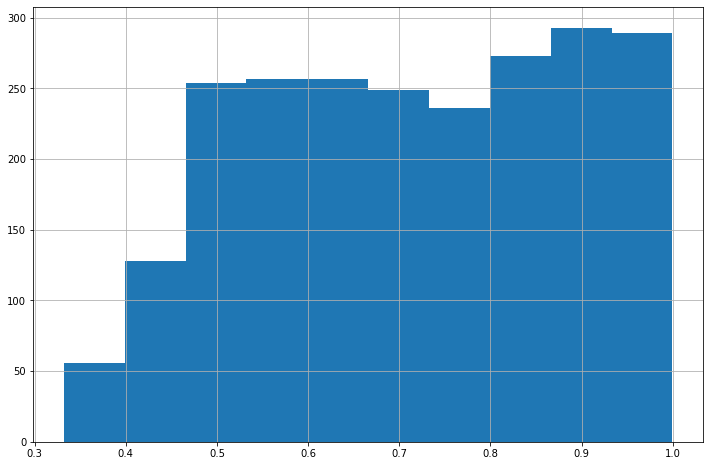

In [101]:
# View Spotify Daily Charts Tracks' histogram of probabilities
plt.figure(figsize=(12, 8))
chart_tracks_df['predicted_genre_prob'].hist()
plt.show();

# 
# Classify *Nyoy Volante's* Tracks

In [102]:
artist_name = 'Nyoy Volante'
artist_tracks_df = pd.read_csv('data/'+artist_name.lower()+'_album_tracks_data.csv')
artist_tracks_df = artist_tracks_df[artist_tracks_df['artist_name']==artist_name]\
.drop_duplicates(subset=['track_name']).reset_index()
artist_tracks_df = create_prediction_df(artist_tracks_df, best_model)
# mapping genres and proba before saving 
artist_tracks_df = map_genres_proba(artist_tracks_df)
save_df_to_csv(artist_tracks_df, 'NyoyVolante_predicted_genres')

artist_tracks_df

Saved DataFrame with shape: (84, 26)


,index,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,...,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,predicted_genre_id,predicted_genre_prob,predicted_genre,classification_probability
46,46,7nsiWbURKfKq1IVtS3b2Yy,Ain't Nothin' Gonna Keep Me From You,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,2A48roBpFpFjatWtksmsQE,288186,2008-05-06,23,0.635,...,0.003670,0.1070,0.509,109.058,7nsiWbURKfKq1IVtS3b2Yy,7nsiWbURKfKq1IVtS3b2Yy,3,0.995405,Acoustic,99.54053163528442%
52,52,4UbeLhCrFKH3Krh0o4sH8W,What's Forever For,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,2A48roBpFpFjatWtksmsQE,228800,2008-05-06,19,0.486,...,0.000347,0.0752,0.397,78.882,4UbeLhCrFKH3Krh0o4sH8W,4UbeLhCrFKH3Krh0o4sH8W,3,0.991131,Acoustic,99.11309480667114%
56,56,4y8KJSy4R3dIwVWHHMt1lf,Dreaming of You,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,2A48roBpFpFjatWtksmsQE,246573,2008-05-06,23,0.569,...,0.000326,0.1310,0.491,78.656,4y8KJSy4R3dIwVWHHMt1lf,4y8KJSy4R3dIwVWHHMt1lf,3,0.990258,Acoustic,99.02576208114624%
11,11,7JIGvuVUQEzaWdDQglFP0S,Bukas Na Lang Kita Mamahalin,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,5jzfPxlD5UD4Aw3cEnelcC,254986,2012-01-01,21,0.575,...,0.015900,0.1020,0.156,75.028,7JIGvuVUQEzaWdDQglFP0S,7JIGvuVUQEzaWdDQglFP0S,3,0.987846,Acoustic,98.78464341163635%
37,37,2J0Ovh75YIhRGHHTLapTJJ,You Left Me,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,1maIgsJ7htTqCDrhe8aucE,243480,2008-08-09,2,0.374,...,0.019100,0.1040,0.340,154.851,2J0Ovh75YIhRGHHTLapTJJ,2J0Ovh75YIhRGHHTLapTJJ,3,0.983607,Acoustic,98.36065769195557%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,62,0PhKUUh0XzAHev6opemDtH,'Di Na Mapigilan,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4EQ7a4ztLVN5OUgxJJVIxY,263186,2002-06-01,1,0.567,...,0.000000,0.0910,0.558,171.918,0PhKUUh0XzAHev6opemDtH,0PhKUUh0XzAHev6opemDtH,5,0.436091,Rock,43.60913932323456%
24,24,079YDRVV6NaioJUkWD1YWG,Try,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4aW4RCeWwmde6JSVjDUgaD,224240,2010-01-01,2,0.483,...,0.000024,0.1110,0.308,139.733,079YDRVV6NaioJUkWD1YWG,079YDRVV6NaioJUkWD1YWG,4,0.426996,R&B,42.69959628582001%
61,61,3RYkG7WmnRK6HSejhCo7jw,Ikaw Lang Para Sa Akin,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4EQ7a4ztLVN5OUgxJJVIxY,259746,2002-06-01,8,0.394,...,0.000000,0.0645,0.543,200.132,3RYkG7WmnRK6HSejhCo7jw,3RYkG7WmnRK6HSejhCo7jw,4,0.342987,R&B,34.29873883724213%
71,71,3V8UIN1Xli8KmgyevIle2Y,Awit Ko Na Naisulat Dahil Sa Kagandahan Mo,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,5S0ZDnuNJpjlN9YiHYpsCW,236419,2020-07-10,12,0.689,...,0.000806,0.0882,0.673,100.066,3V8UIN1Xli8KmgyevIle2Y,3V8UIN1Xli8KmgyevIle2Y,5,0.325525,Rock,32.55248665809631%


In [103]:
# Check Artist Tracks' classified genres with but low (< 50%) probability 
artist_tracks_df[artist_tracks_df['predicted_genre_prob'] < .5]

,index,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,...,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,predicted_genre_id,predicted_genre_prob,predicted_genre,classification_probability
66,66,1LsiUfQrvGHewEnzyipf6j,Love At First Sight,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4EQ7a4ztLVN5OUgxJJVIxY,218720,2002-06-01,1,0.597,...,0.000000,0.0990,0.639,95.071,1LsiUfQrvGHewEnzyipf6j,1LsiUfQrvGHewEnzyipf6j,5,0.498929,Rock,49.892857670784%
27,27,4M6YrTyOE1PWLIx1bqVcaA,In You,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4aW4RCeWwmde6JSVjDUgaD,292800,2010-01-01,7,0.586,...,0.012300,0.1110,0.515,87.603,4M6YrTyOE1PWLIx1bqVcaA,4M6YrTyOE1PWLIx1bqVcaA,3,0.497107,Acoustic,49.71071183681488%
9,9,5U2YOPnIrggKoelaNJVLkj,Miss Kita,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,5jzfPxlD5UD4Aw3cEnelcC,295626,2012-01-01,9,0.588,...,0.000269,0.3160,0.631,169.919,5U2YOPnIrggKoelaNJVLkj,5U2YOPnIrggKoelaNJVLkj,4,0.482179,R&B,48.21787178516388%
21,21,5otfMfCkxtpG9JKeuINH5h,Miss Kita - Instrumental,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4oif6qMFEOF3E6uf0bvDOV,298786,2012-01-01,1,0.721,...,0.800000,0.3480,0.502,85.006,5otfMfCkxtpG9JKeuINH5h,5otfMfCkxtpG9JKeuINH5h,5,0.458757,Rock,45.87571620941162%
67,67,2eBPqjjEk3OXdObmcICE2l,May Aasahan Ba,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4EQ7a4ztLVN5OUgxJJVIxY,267506,2002-06-01,0,0.651,...,0.000000,0.1700,0.522,132.243,2eBPqjjEk3OXdObmcICE2l,2eBPqjjEk3OXdObmcICE2l,5,0.447365,Rock,44.73653733730316%
64,64,4KJVryttL1duMPn0gqWVM7,Tunay Na Tunay,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4EQ7a4ztLVN5OUgxJJVIxY,294906,2002-06-01,6,0.560,...,0.000000,0.0539,0.451,79.999,4KJVryttL1duMPn0gqWVM7,4KJVryttL1duMPn0gqWVM7,5,0.437294,Rock,43.729403614997864%
62,62,0PhKUUh0XzAHev6opemDtH,'Di Na Mapigilan,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4EQ7a4ztLVN5OUgxJJVIxY,263186,2002-06-01,1,0.567,...,0.000000,0.0910,0.558,171.918,0PhKUUh0XzAHev6opemDtH,0PhKUUh0XzAHev6opemDtH,5,0.436091,Rock,43.60913932323456%
24,24,079YDRVV6NaioJUkWD1YWG,Try,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4aW4RCeWwmde6JSVjDUgaD,224240,2010-01-01,2,0.483,...,0.000024,0.1110,0.308,139.733,079YDRVV6NaioJUkWD1YWG,079YDRVV6NaioJUkWD1YWG,4,0.426996,R&B,42.69959628582001%
61,61,3RYkG7WmnRK6HSejhCo7jw,Ikaw Lang Para Sa Akin,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4EQ7a4ztLVN5OUgxJJVIxY,259746,2002-06-01,8,0.394,...,0.000000,0.0645,0.543,200.132,3RYkG7WmnRK6HSejhCo7jw,3RYkG7WmnRK6HSejhCo7jw,4,0.342987,R&B,34.29873883724213%
71,71,3V8UIN1Xli8KmgyevIle2Y,Awit Ko Na Naisulat Dahil Sa Kagandahan Mo,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,5S0ZDnuNJpjlN9YiHYpsCW,236419,2020-07-10,12,0.689,...,0.000806,0.0882,0.673,100.066,3V8UIN1Xli8KmgyevIle2Y,3V8UIN1Xli8KmgyevIle2Y,5,0.325525,Rock,32.55248665809631%


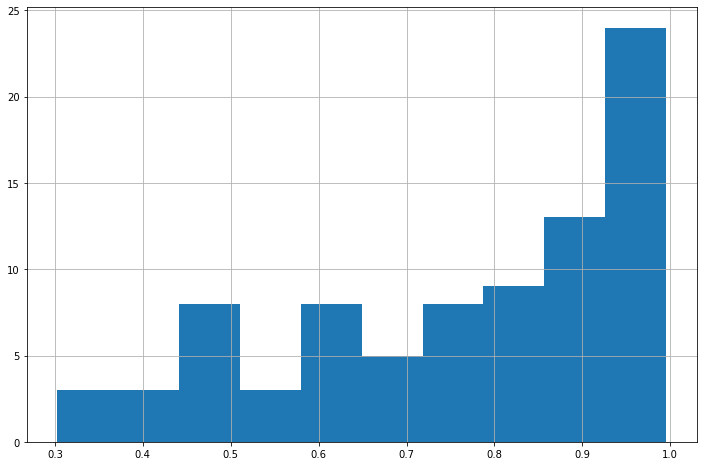

In [104]:
# View Artist Tracks' histogram of probabilities
plt.figure(figsize=(12, 8))
artist_tracks_df['predicted_genre_prob'].hist()
plt.show();

In [105]:
print(f'\nArtist: {artist_name}')
cols = ['track_name', 'release_date', 'popularity', 'predicted_genre', 'classification_probability']
artist_tracks_df = artist_tracks_df[cols].reset_index()
artist_tracks_df


Artist: Nyoy Volante


,index,track_name,release_date,popularity,predicted_genre,classification_probability
0,46,Ain't Nothin' Gonna Keep Me From You,2008-05-06,23,Acoustic,99.54053163528442%
1,52,What's Forever For,2008-05-06,19,Acoustic,99.11309480667114%
2,56,Dreaming of You,2008-05-06,23,Acoustic,99.02576208114624%
3,11,Bukas Na Lang Kita Mamahalin,2012-01-01,21,Acoustic,98.78464341163635%
4,37,You Left Me,2008-08-09,2,Acoustic,98.36065769195557%
...,...,...,...,...,...,...
79,62,'Di Na Mapigilan,2002-06-01,1,Rock,43.60913932323456%
80,24,Try,2010-01-01,2,R&B,42.69959628582001%
81,61,Ikaw Lang Para Sa Akin,2002-06-01,8,R&B,34.29873883724213%
82,71,Awit Ko Na Naisulat Dahil Sa Kagandahan Mo,2020-07-10,12,Rock,32.55248665809631%


# TODOs

In [106]:
######### [ ADD SOME SPICE  ] ##############
## IF
     ## FEATURES ['danceability', 'key' ...... 'n_features']    =>    GENRE_CLASSIFICATION  
          ## GENRE_CLASSIFICATION     =>     chart_tracks_df []      GENRE + POPULARITY +   

        
        
##  ELSE   IF 
    ## FEATURES ['danceability', 'key' ...... 'n_features']    
         ##  =>    TRACKS    based on  cosine distance 

        
        
######### [ RETAIN NYO RECOMMENDER ]   #########
## DEFAULT  (SIMILAR from EXISTING ARTIST'S TRACKS by GENRES)   
    ## FEATURES ['danceability', 'key' ...... 'n_features']   from EXISTING ARTIST'S TRACKS  
         ##  =>    TRACKS    based on  cosine distance 





        
        